# Libraries

In [461]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from scipy.stats import boxcox

# Setup

In [392]:
pd.set_option('display.max_rows', 50)

# Load data

In [520]:
data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

print(data.shape)
print(data.head())

(100000, 12)
   PassengerId  Survived  Pclass              Name   Sex    Age  SibSp  Parch  \
0            0         1       1  Oconnor, Frankie  male    NaN      2      0   
1            1         0       3       Bryan, Drew  male    NaN      0      0   
2            2         0       3    Owens, Kenneth  male   0.33      1      2   
3            3         0       3     Kramer, James  male  19.00      0      0   
4            4         1       3     Bond, Michael  male  25.00      0      0   

      Ticket   Fare   Cabin Embarked  
0     209245  27.14  C12239        S  
1      27323  13.35     NaN        S  
2  CA 457703  71.29     NaN        S  
3   A. 10866  13.04     NaN        S  
4     427635   7.76     NaN        S  


In [535]:
from sklearn.preprocessing import PolynomialFeatures
data_ = data[['PassengerId', 'Pclass']]

inter = PolynomialFeatures(interaction_only=True, include_bias=False)
inter.fit(data_)
# print(type(inter.get_feature_names()))
# data_[np.array(inter.get_feature_names())] = inter.transform(data_)
d = pd.DataFrame(data=inter.transform(data_), columns=inter.get_feature_names())
# d.head()
data_.join(d)

,PassengerId,Pclass,x0,x1,x0 x1
0,0,1,0.0,1.0,0.0
1,1,3,1.0,3.0,3.0
2,2,3,2.0,3.0,6.0
3,3,3,3.0,3.0,9.0
4,4,3,4.0,3.0,12.0
...,...,...,...,...,...
99995,99995,2,99995.0,2.0,199990.0
99996,99996,2,99996.0,2.0,199992.0
99997,99997,3,99997.0,3.0,299991.0
99998,99998,3,99998.0,3.0,299994.0


In [515]:
# profile = ProfileReport(data, title='Pandas Profiling Report', explorative=True)
# profile.to_notebook_iframe()

<AxesSubplot:xlabel='Age', ylabel='Count'>

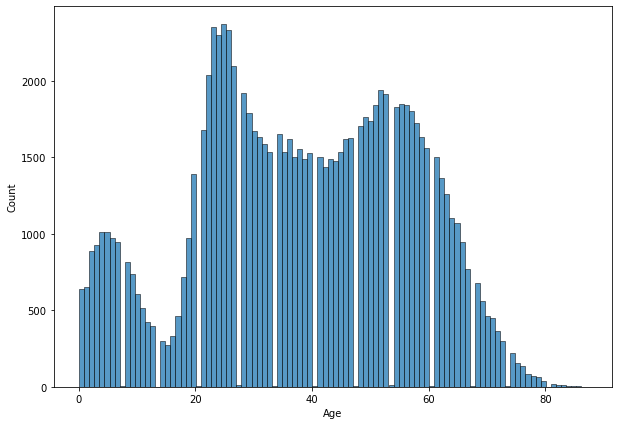

In [513]:
plt.figure(figsize=(10, 7))
sns.histplot(data['Age'], bins=100)

In [482]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [485]:
data.isnull().sum()

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age             3292
SibSp              0
Parch              0
Ticket          4623
Fare             134
Cabin          67866
Embarked         250
dtype: int64

In [510]:
bins = [4, 10, 20, 40, 60]
labels = range(len(bins) - 1)
age_bins = pd.cut(data['Age'], bins=bins, labels=labels)
data_['Age_Bins'] = age_bins
data_['Age_Bins'] = pd.qcut(data['Age'], q=5, labels=False)
data_.groupby(by=['Sex', 'Age_Bins', 'Survived']).Survived.count()

Sex     Age_Bins  Survived
female  0.0       0           2755
                  1           6630
        1.0       0           2242
                  1           5471
        2.0       0           2473
                  1           6202
        3.0       0           2421
                  1           6080
        4.0       0           2312
                  1           5737
male    0.0       0           9259
                  1           2363
        1.0       0           7868
                  1           2092
        2.0       0           8887
                  1           2254
        3.0       0           8817
                  1           2285
        4.0       0           8177
                  1           2138
Name: Survived, dtype: int64

In [498]:
impute_data = data.groupby(by=['Sex', 'Embarked', 'Pclass']).Fare.median().reset_index()
# data.loc[data.isnull(), ['Sex', 'Embarked', 'Pclass']]
data_ = data.merge(impute_data, on=['Sex', 'Embarked', 'Pclass'])
data_.head()
data_['Fare'] = np.where(data_['Fare_x'].isnull(), data_['Fare_y'], data_['Fare_x'])
data_.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare_x,Cabin,Embarked,Fare_y,Fare
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S,31.88,27.14
1,8,0,1,"Wardlaw, Michael",male,27.0,2,1,474849,73.02,A7253,S,31.88,73.02
2,11,0,1,"Telschow, Robert",male,60.0,0,0,19600,31.50,A9055,S,31.88,31.50
3,17,0,1,"Geiger, Maria",male,43.0,0,0,487299,29.84,NaN,S,31.88,29.84
4,21,0,1,"Andrews, Tommie",male,39.0,1,0,43632,30.72,NaN,S,31.88,30.72


In [500]:
data_.isnull().sum()

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age             3290
SibSp              0
Parch              0
Ticket          4614
Fare_x           133
Cabin          67704
Embarked           0
Fare_y             0
Fare               0
dtype: int64

In [486]:
data.groupby(by=['Sex', 'Embarked', 'Pclass']).Fare.median()

Sex     Embarked  Pclass
female  C         1         75.810
                  2         26.445
                  3         23.360
        Q         1         69.100
                  2         24.660
                  3         11.780
        S         1         66.175
                  2         24.445
                  3         13.060
male    C         1         69.505
                  2         24.535
                  3         12.550
        Q         1         66.510
                  2         23.500
                  3         10.240
        S         1         31.880
                  2         13.010
                  3         10.330
Name: Fare, dtype: float64

<AxesSubplot:xlabel='Age', ylabel='Count'>

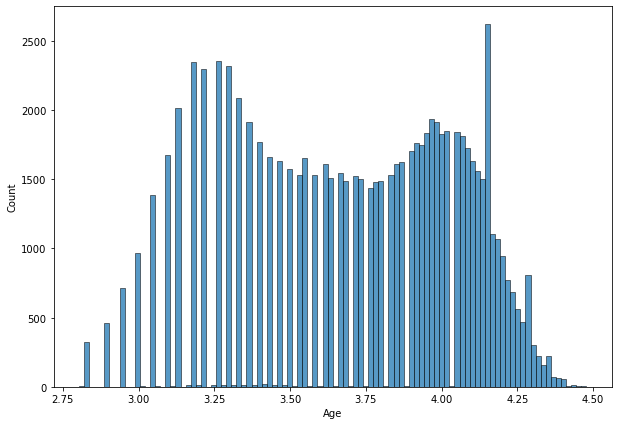

In [478]:
plt.figure(figsize=(10, 7))
# sns.histplot(np.log1p(data['Fare']), bins=100)
d = np.log1p(data['Age'])
sns.histplot(d[d>2.8], bins=100)
# sns.histplot(boxcox(data['Age'])[0], bins=100)

## Description of the attributes

* PassengerId - Unique passenger id
* Survived - Flag whether passenger survived or not
* Pclass - Ticket class
* Name - Name of the passenger
* Sex - Gender of the passenger
* Age - Age of the passenger
* SibSp - # of siblings / spouses aboard the Titanic:
    * Siblings: brother, sister, stepbrother, stepsister
    * Spouse: husband, wife (mistresses and fiancés were ignored)
* Parch - # of parents / children aboard the Titanic:
    * Parent: mother, father
    * Child: daughter, son, stepdaughter, stepson
* Ticket - Ticket number
* Fare - Passenger fare
* Cabin - Cabin number
* Embarked - Port of embarkation:
    * C = Cherbourg
    * Q = Queenstown
    * S = Southampton

In [439]:
data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
count,100000.000000,100000.000000,100000.000000,100000,100000,96708.000000,100000.000000,100000.000000,99866.00000,32134,99750
unique,NaN,NaN,NaN,92144,2,NaN,NaN,NaN,NaN,26992,3
top,NaN,NaN,NaN,"Johnson, John",male,NaN,NaN,NaN,NaN,C19828,S
freq,NaN,NaN,NaN,31,56114,NaN,NaN,NaN,NaN,6,72139
mean,49999.500000,0.427740,2.106910,NaN,NaN,38.355472,0.397690,0.454560,43.92933,NaN,NaN
std,28867.657797,0.494753,0.837727,NaN,NaN,18.313556,0.862566,0.950076,69.58882,NaN,NaN
min,0.000000,0.000000,1.000000,NaN,NaN,0.080000,0.000000,0.000000,0.68000,NaN,NaN
25%,24999.750000,0.000000,1.000000,NaN,NaN,25.000000,0.000000,0.000000,10.04000,NaN,NaN
50%,49999.500000,0.000000,2.000000,NaN,NaN,39.000000,0.000000,0.000000,24.46000,NaN,NaN
75%,74999.250000,1.000000,3.000000,NaN,NaN,53.000000,1.000000,1.000000,33.50000,NaN,NaN


## Null values

In [440]:
data.isna().sum()

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age             3292
SibSp              0
Parch              0
Fare             134
Cabin          67866
Embarked         250
dtype: int64